In [1]:
using Plots, LaTeXStrings
using STMO
using Images, Colors

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1278


# Motivation

# Motivating example: a party in the research group

Let's have a party in our research unit! Pastries and party hats for everyone! We ask Tinne, our laboratory manager, to make some desserts: an airy merveilleux, some delicious eclairs, a big bowl of dark chocolate mousse, a sweet passion fruit-flavored bavarois and moist carrot cake (we got to have our vegetables). If we mentally cut all these sweets into portions, we have twenty portions.

In [2]:
staff = ["Bernard", "Jan", "Willem", "Hilde", "Steffie", "Marlies", "Tim", "Wouter"]
desserts = ["merveilleux", "eclair", "chocolate mousse", "bavarois", "carrot cake"]

5-element Array{String,1}:
 "merveilleux"
 "eclair"
 "chocolate mousse"
 "bavarois"
 "carrot cake"

Since this is academia, we respect the hierarchy: people higher on the ladder are allowed to take more dessert. The professors, Bernard, Jan and Willem each get three pieces each, our senior post-doc Hilde will take four portions (one for each of her children) and the teaching assistants are allowed two portions per person. Since Wouter is a shared teaching assistant with the Biomath research group, he can only take one (sorry Wouter).

In [3]:
# portions per person
a = [3.0, 3, 3, 4, 2, 2, 2, 1]
# quantities of each dessert
b = [4.0, 2, 6, 4, 4]

5-element Array{Float64,1}:
 4.0
 2.0
 6.0
 4.0
 4.0

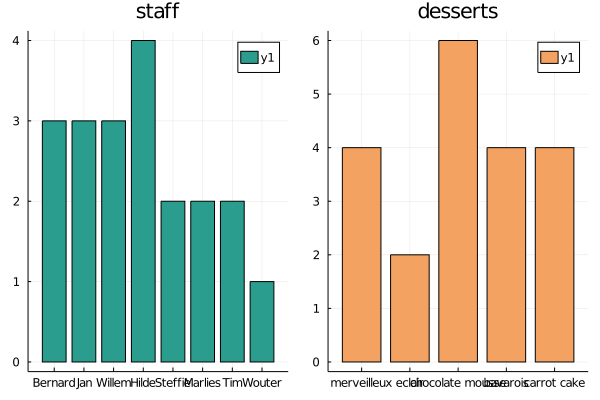

In [4]:
ha = bar(a, color=mygreen, title="staff");
xticks!(1:8, staff)
hb = bar(b, color=myorange, title="desserts");
xticks!(1:5, desserts)
plot(ha, hb)

As engineers and mathematicians, we pride ourselves in doing things the optimal way. So how can we divide the desserts to make everybody as happy as possible? As I am preparing a course on optimization, I went around and asked which of those treats they liked. On a scale between -2 and 2, with -2 being something they hated and 2 being their absolute favorite, the desert preferences of the teaching staff is given below (students: take note!).

In [5]:
preferences = [2 2 1 0 0;
              0 -2 -2 -2 2;
              1 2 2 2 -1;
              2 1 0 1 -1;
              0.5 2 2 1 0;
              0 1 1 1 -1;
             -2 2 2 1 1;
              2 1 2 1 -1]

C = -preferences;  # cost

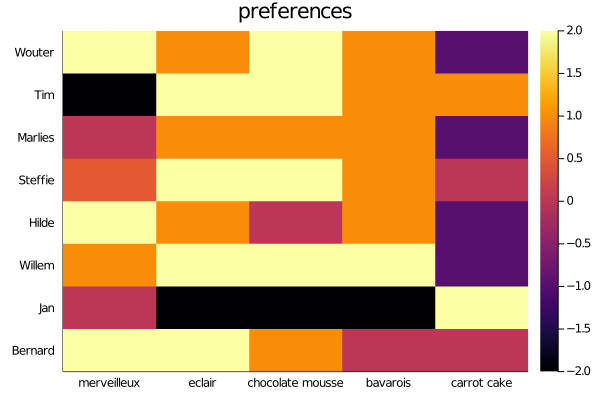

In [56]:
heatmap(preferences, title="preferences")
yticks!(1:8, staff)
xticks!(1:5, desserts)

In [55]:
heatmap(preferences, title="preferences", color=:"pu_or")
yticks!(1:8, staff)
xticks!(1:5, desserts)

LoadError: Unknown color: pu_or

See how most people like eclairs and chocolate mousse, but merveilleus are a more polarizing dessert! Jan is lactose intolerant, so he only gave a high score to the carrot cake by default.

The task is clear: divide these desserts in such a way that people get their portions of the kinds they like the most!

# The Monge problem

The original version of optimal transport was formulated by Gaspard Monge in 1781. Here, $n=m$ and the goal is to connect $n$ sources with $n$ sinks to minimize a cost:
$$
\min_{\sigma\in\text{Perm(n)}} \frac{1}{n}\sum_{i=1}^nC_{i,\sigma(i)}\,,
$$
with $\text{Perm(n)}$ the set of all permutation of $n$ elements.

> **Example**: There are $n$ mines mining iron ore and a collection of $n$ factories. Given a distance between every mine and every factory, select one factory for every mine such that the total cost (=transportation distance) is minimized.

The **Monge problem** is a *discrete combinatorial optimization problem*:

- The size of the search space is $n!$, for $n=70$, there are more than $10^{100}$ permutations!
- Can be solved using the [Hungarian algorithm](https://en.wikipedia.org/wiki/Hungarian_algorithm).
- Restrictive: two sets to match must be of same size. How to deal with different weights?

For working with probability distributions, we require a way to perform *soft-matching*.

## Exercise: cell tracking

In a microscopy imaging experiment we monitor ten moving cells at time $t_1$ and some time later at time $t_2$. Between these times, the cells have moved. An image processing algorithm determined the coordinates of every cell in the two images. We want to know which cell in the first corresponds to the second image. To this end, search the assignment that minimizes the sum of the squared Euclidian distances between cells from the first image versus the corresponding cell of the second image.

1. `X1` and `X2` contain the $x,y$ coordinates of the cells for the two images. Compute the matrix $C$ containing the pairwise squared Euclidean distance. You can use the function `dist` provide by the `STMO` library.
2. Complete the function `monge_brute_force` to use brute-force search for the best permutation. You might find the function `permutations` from the `Combinatorics` library useful. How large is your search space? Time your function.
3. Make a plot connecting the cells.

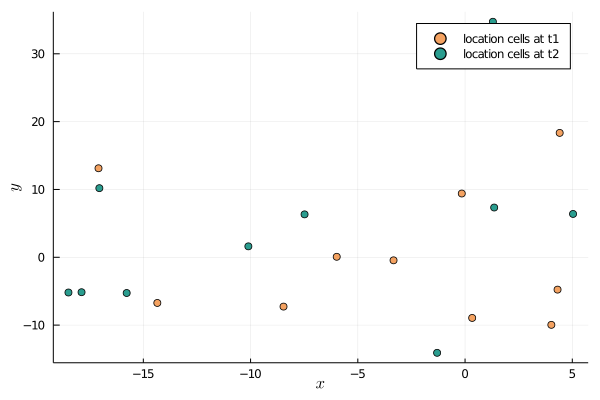

In [25]:
using STMO.OptimalTransport: X1, X2

scatter(X1[:,1], X1[:,2], color=myorange, label="location cells at t1")
xlabel!("\$x\$")
ylabel!("\$y\$")
scatter!(X2[:,1], X2[:,2], color=mygreen, label="location cells at t2")

In [26]:
using Combinatorics: permutations

for p in permutations([1, 2, 3])
   println(p)
end

[1, 2, 3]
[1, 3, 2]
[2, 1, 3]
[2, 3, 1]
[3, 1, 2]
[3, 2, 1]


In [46]:
function monge_brute_force(C)
  n, m = size(C)
  @assert n == m "C should be square"
    # loop over all permutations and to find the
    # matching with the lowest cost
  best_cost = typemax(eltype(C))
  for p in permutations(1:n) 
        cost = zero(eltype(C))
        for (i,j) in enumerate(p)
            cost += C[i,j]
        end
        if cost < best_cost
            best_cost = cost
            global best_perm = p
        end
    end
  return best_perm, best_cost
end

monge_brute_force (generic function with 1 method)

In [47]:
# get the cost matrix (i.e. pairwise squared Euclidean)
# Euclidean distances between the cells at the different times)
import STMO: dist  # Euclidean distance

C = dist(X1,X2).^2 # pairwise squared Euclidean
best_perm, best_cost = monge_brute_force(C)


([10, 4, 7, 3, 6, 8, 1, 2, 9, 5], 932.0230797201436)

In [32]:
C = dist(X1,X2).^2

10×10 Array{Float64,2}:
 178.012    116.811    190.116   301.333    …  1258.8     82.6205    63.1332
 339.888    534.844    989.612     8.60213      804.796  373.811    138.471
   4.19338  547.886    224.243   293.708       1963.68   444.594    217.694
 414.059    268.374     45.3867  850.175       2004.46   306.289    397.706
  57.4953   368.828     97.7329  378.634       1859.1    309.824    185.878
 964.734    143.171   1084.08    527.001    …   278.272  130.389    285.753
 273.003    257.185     29.1405  668.218       1907.94   266.03     294.242
 403.806    125.019    118.37    680.126       1568.96   155.235    262.243
 459.208     35.9862   553.008   286.135        643.502    6.54894   63.1745
 124.417    161.295    222.414   224.842       1253.88   106.636     41.3638

In [51]:
# make a plot with the connections of the cells
for (i,j) in enumerate(perm)
    plot!(p,[X1[i,1], X2[j,1]], [X1[i,2], X2[j,2]], label="", color=myred, alpha =0.8, lw=2)
end

LoadError: UndefVarError: perm not defined

In [52]:
p

LoadError: UndefVarError: p not defined

In [50]:
# get matching

best_perm, best_cost = monge_brute_force(C)

([10, 4, 7, 3, 6, 8, 1, 2, 9, 5], 932.0230797201436)

In [ ]:
# make a plot with the connections of the cells

# The optimal transport problem

Let us introduce some notation so we can formally state this as an optimization problem. Let $\mathbf{a}$ be the vector containing the amount of dessert every person may eat. In this case $\mathbf{a} = [3,3,3,4,2,2,2,1]^\intercal$ (in general the dimension of $\mathbf{r}$ is $n$). Similarly, $\mathbf{c}$ denotes the vector of how much there is of every dessert, i.e. $\mathbf{b}=[4, 2, 6, 4, 4]^\intercal$ (in general the dimension of $\mathbf{b}$ is $m$). Often $\mathbf{a}$ and $\mathbf{b}$ represent marginal probability distributions, hence their values are nonzero sum to one.

Let $U(\mathbf{a}, \mathbf{b})$ be the set of positive $n\times m$ matrices for which the rows sum to $\mathbf{a}$ and the columns sum to $\mathbf{b}$:

$$
U(\mathbf{a}, \mathbf{b}) = \{P\in \mathbb{R}_{>0}^{n\times m}\mid P\mathbf{1}_m = \mathbf{a}, P^\intercal\mathbf{1}_n = \mathbf{b}\}\,.
$$

For our problem, $U(\mathbf{a}, \mathbf{b})$ contains all the ways of dividing the desserts for my colleagues. Note that we assume here that we can slice every dessert however we like. We do not have only to give whole pieces of pie but can provide any fraction we want.

The preferences of each person for each dessert is also stored in a matrix. To be consistent with the literature, this will be stored in a $n\times m$ *cost* matrix $C$. The above matrix is a preference matrix that can easily be changed into a cost matrix by flipping the sign of every element.

So finally, the problem we want to solve is formally posed as

$$
d_C(\mathbf{r}, \mathbf{c}) = \min_{P\in U(\mathbf{a}, \mathbf{b})}\, \sum_{i,j}P_{ij}C_{ij}\,.
$$

This is called the *optimal transport* between $\mathbf{a}$ and $\mathbf{b}$. It can be solved relatively easily using linear programming.

The optimum, $d_C(\mathbf{a}, \mathbf{b})$, is called the *Wasserstein metric*. It is basically a distance between two probability distributions. It is sometimes also called the *earth mover distance* as it can be interpreted as how much 'dirt' you have to move to change one 'landscape' (distribution) in another.

# Choosing a bit of everything

Consider a slightly modified form of the optimal transport:

$$
d_C^\lambda(\mathbf{a}, \mathbf{b}) = \min_{P\in U(\mathbf{a}, \mathbf{b})}\, \sum_{i,j}P_{ij}C_{ij} - \frac{1}{\lambda}H(P)\,,
$$

in which the minimizer $d^\lambda_C(\mathbf{a}, \mathbf{b})$ is called the *Sinkhorn distance*. Here, the extra term

$$
H(P) = -\sum_{i,j}P_{ij}\log P_{ij}
$$

is the *information entropy* of $P$. One can increase the entropy by making the distribution more homogeneous, i.e., giving everybody a more equal share of every dessert. The parameter $\lambda$ determines the trade-off between the two terms: trying to give every person only their favorites or encouraging equal distributions. Machine learners will recognize this as similar to regularization in, for example, ridge regression. Similar to that for machine learning problems, a tiny bit of shrinkage of the parameter can lead to improved performance, the Sinkhorn distance is also observed to work better than the Wasserstein distance on some problems. This is because we use a very natural prior on the distribution matrix $P$: in the absence of a cost, everything should be homogeneous!

If you squint your eyes a bit, you can also recognize a Gibbs free energy minimization problem into this, containing energy, entropy, physical restrictions ($U(\mathbf{a}, \mathbf{b})$) and a temperature ($1/\lambda$). This could be used to describe a system of two types of molecules (for example proteins and ligands) which have a varying degree of cross-affinity for each other.

## An elegant algorithm for Sinkhorn distances

Even though the entropic regularization can be motivated, to some extent, it appears that we have made the problem harder to solve because we added an extra term. Remarkably, there exists a very simple and efficient algorithm to obtain the optimal distribution matrix $P_\lambda^\star$ and the associated $d_C^\lambda(\mathbf{a}, \mathbf{b})$! This algorithm starts from the observation that the elements of the optimal distribution matrices are of the form

$$
(P_\lambda^\star)_{ij} = \alpha_i\beta_j e^{-\lambda C_{ij}}\,,
$$

with $\alpha_1,\ldots,\alpha_n$ and $\beta_1,\ldots,\beta_n$ some constants that have to be determined such that the rows, resp. columns, sum to $\mathbf{r}$, resp. $\mathbf{c}$! The optimal distribution matrix can be obtained by the following algorithm.

> **given**: cost matrix $C$, marginals $\mathbf{a}$, $\mathbf{a}$ and $\lambda\ge0$
>
> **initialize**: $P_\lambda = e^{-\lambda C}$
>
> **repeat**
>> 1. **scale the rows** such that the row sums match $\mathbf{a}$
>> 2. **scale the columns** such that the column sums match $\mathbf{b}$
>
> **until** convergence

**Assignments**
1. Complete the code below to solve optimal transport using the Sinkhorn algorithm.
2. Solve the dessert problem, once for $\lambda=0.1$ and once for $\lambda=10$.

In [63]:
function sinkhorn(C::Matrix, a::Vector, b::Vector; λ=1.0, ϵ=1e-8)
    n, m = size(C)
    @assert n == length(a) && m == length(b) throw(DimensionMismatch("a and b do not match"))
    @assert sum(a) ≈ sum(b) "a and b don't have equal sums"
    u, v = copy(a), copy(b)
    M = exp.(-λ * C)  # element wise
    # normalize this matrix
    while maximum(abs.(a .- Diagonal(u) * (M * v))) > ϵ
        u .= a ./ (M * v) # scale u
        v .= b ./ (M' * u) # scale v
      end
    return Diagonal(u) * M * Diagonal(v)
  end

sinkhorn (generic function with 1 method)

In [62]:
using LinearAlgebra # for diagonal function

In [64]:
Plow = sinkhorn(-preferences, a, b, λ=0.1) # solve the dessert problem for λ=0.1

8×5 Array{Float64,2}:
 0.653002  0.319842   0.894453  0.550763  0.58194
 0.623269  0.249941   0.772483  0.525685  0.828623
 0.572079  0.309675   0.957102  0.65132   0.509824
 0.904751  0.400978   1.12135   0.843352  0.729564
 0.367225  0.208976   0.645875  0.3977    0.380224
 0.374689  0.202825   0.626864  0.426589  0.369032
 0.292016  0.213376   0.659474  0.406074  0.42906
 0.212969  0.0943862  0.322396  0.198517  0.171732

In [65]:
Phigh = sinkhorn(-preferences, a, b, λ=10.0) # solve the dessert problem for λ=10

8×5 Array{Float64,2}:
 0.799159     1.99569      0.112086     9.05856e-6   0.0930607
 1.09448e-16  5.6335e-25   6.96918e-22  1.24061e-21  3.0
 1.58534e-8   0.000872018  1.07877      1.92036      1.8461e-9
 3.20052      0.000362856  2.03795e-5   0.799082     1.69203e-5
 1.97855e-10  0.00161519   1.99815      0.000161486  7.53179e-5
 1.05688e-8   0.000581337  0.719171     1.28022      2.71083e-5
 1.50198e-21  0.000882881  1.09221      8.82702e-5   0.90682
 0.000323565  3.66839e-8   0.999596     8.07853e-5   1.71061e-9

Using this algorithm, we can compute the optimal distribution of desserts, shown below.

![The solution of the dessert problem with $\lambda=10$, an excellent approximation of the unregularized problem.](Figures/desserts_high_lamda.png)

Here, everybody only has desserts they like. Note that for example, Jan gets three pieces of carrot cake (the only thing he can eat) while Tim receives the remaining portion (he is the only person with some fondness of this dessert). If we decrease the regularization parameter $\lambda$, we encourage a more homogeneous distribution, though some people will have to try some sweets which are not their favorites...

![The solution with a slightly lower $\lambda$. Clearly, a different optimal distribution is obtained.](Figures/desserts_low_lamda.png)

The optimal transport problem, with or without entropic regularization has a beautiful geometric interpretation, shown below.

![A geometric view of the optimal transport problem.](Figures/optimal_transport_geometric.png)

The cost matrix determines a direction in which distributions are better or worse. The set $U(\mathbf{r}, \mathbf{c})$ contains all feasible distributions. In the unregularized case, the optimum $P^\star$ is usually found in one of the corners of such a set. When adding the entropic regularizer, we restrict ourselves to distributions with a minimum of entropy, lying within the smooth red curve. Because we don't have to deal with the sharp corners of $U(\mathbf{r}, \mathbf{c})$ anymore, it is easier to find the optimum. As special cases, when $\lambda\rightarrow \infty$, then $P^\star_\lambda$ will become closers to $P^\star$ (until the algorithm runs into numerical difficulties). For $\lambda\rightarrow 0$ on the other hand, only the entropic term is taken into account and $P_\lambda^\star=\mathbf{a}\mathbf{b}^\intercal$. This is bivariate distribution where the rows and columns are independent.

# Application: color transfer

In this exercise, we will apply optimal transportation to transfer the color scheme of one image to the other. We will read two images and exact the colors of the pixels (RGB encoded). Using optimal transport, a softmatching can be obtained between the pixels of te repective images. Then, every pixel of the first image can be recomputed using a weighted sum of the pixels of the second image (or vice versa).

First, we will load two images. Feel free to use your own!

In [66]:
using Images, Colors

# function to subsample image
subsample(image, every=8) = image[1:every:size(image,1), 1:every:size(image,2)]

subsample (generic function with 2 methods)

┌ Info: Precompiling QuartzImageIO [dca85d43-d64c-5e67-8c65-017450d5d020]
└ @ Base loading.jl:1278


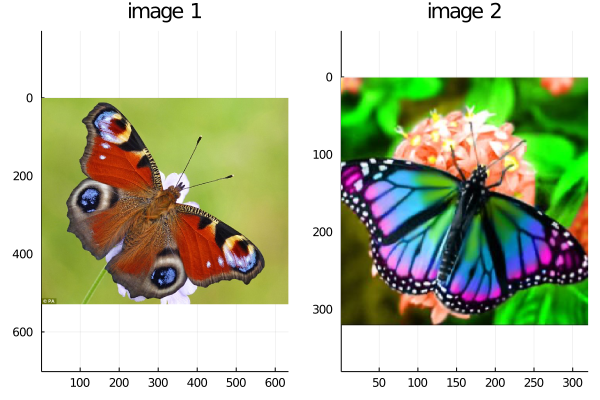

In [68]:
image1 = load("/Users/tristanvanneste/Documents/GitHub/STMO/chapters/06.OptimalTransport/Figures/butterfly3.jpg")
image2 = load("/Users/tristanvanneste/Documents/GitHub/STMO/chapters/06.OptimalTransport/Figures/butterfly2.jpg")

plot(
  plot(image1, title="image 1", aspect_ratio=:equal),
  plot(image2, title="image 2", aspect_ratio=:equal))

We will subsample the images, otherwise we will end up with a huge cost matrix, the dimensions determined by the total number of pixels of the images. Note that we can also randomly subsample pixels or use $k$-means clustering to reduce the problem size.

In [69]:
image1 = subsample(image1);
image2 = subsample(image2);

Take a look at the distribution of colors!

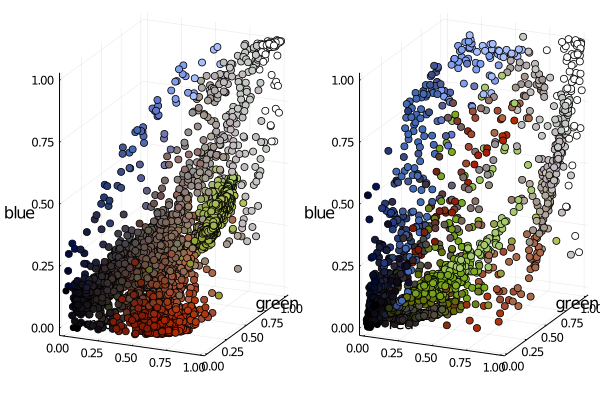

In [70]:
colors1 = vec(image1)
colors2 = vec(image2)

plot(
  colorscatter(colors1, title="figure 1"),
  colorscatter(colors2, title="figure 2"))

The `Colors` package contains a function `colordiff` that quantifies the perceptive difference between two colors. It it an ideal cost function!

In [71]:
# difference between red and green
colordiff(parse(Colorant, myred), parse(Colorant, mygreen))

52.434978652952964

In [72]:
# difference between blue and green
colordiff(parse(Colorant, myblue), parse(Colorant, mygreen))

41.268593464105315

Use this to compute the pairwise distances between all the colors!

In [73]:
C = [colordiff(c1, c2) for c1 in colors1, c2 in colors2]  # compute the cost function between the pixels.

5360×1600 Array{Float64,2}:
 21.4399  20.776   34.8274  46.8067  …  17.0181  37.9223  31.4805  29.2634
 21.2635  20.6484  34.8569  47.2475     17.1904  38.1801  31.7212  29.5025
 20.5782  19.8553  34.1924  48.0064     17.9503  38.7494  32.3239  30.1266
 19.9066  19.3907  34.3465  49.6723     18.6435  39.7158  33.2575  31.0565
 20.0701  19.5014  34.3053  49.2671     18.4682  39.4788  33.026   30.8256
 19.9822  19.5278  34.2392  49.2376  …  18.4456  39.4484  32.9962  30.7964
 19.7459  19.2835  34.3894  50.0688     18.8201  39.9502  33.488   31.2864
 19.7459  19.2835  34.3894  50.0688     18.8201  39.9502  33.488   31.2864
 20.1496  19.642   34.2     48.8243     18.2709  39.2082  32.763   30.564
 19.6562  19.3103  34.3228  50.0394     18.7988  39.9202  33.4589  31.258
 20.1947  19.584   34.6608  49.6101  …  18.4868  39.6553  33.1797  30.9708
 20.5632  19.7981  34.6116  48.8037     18.1514  39.1932  32.7311  30.5236
 20.4933  19.5514  34.4548  48.9461     18.3834  39.3367  32.892   30.692


Then, we can compute the transport between the two collections of pixels. Since every pixel is equally important, we give an uniform weight for each pixel, e.g., $\mathbf{a}=\mathbf{1}_n/m$ and $\mathbf{b}=\mathbf{1}_m/m$

In [74]:
n, m = size(C)
P = sinkhorn(C, ones(n)/n, ones(m)/m , λ = 1)

5360×1600 Array{Float64,2}:
 3.12334e-9  5.89781e-9  3.04639e-9  …  2.11421e-7  3.97856e-7  4.33842e-7
 4.40064e-9  7.91438e-9  3.49347e-9     1.92954e-7  3.69388e-7  4.0342e-7
 1.58665e-8  3.17804e-8  1.23359e-8     1.98404e-7  3.6735e-7   3.92688e-7
 5.10156e-8  8.3081e-8   1.73708e-8     1.23992e-7  2.3722e-7   2.54532e-7
 3.90858e-8  6.71044e-8  1.63331e-8     1.41804e-7  2.69821e-7  2.89322e-7
 4.11088e-8  6.2954e-8   1.68074e-8  …  1.40803e-7  2.67751e-7  2.8694e-7
 6.53553e-8  1.0089e-7   1.81542e-8     1.07009e-7  2.05541e-7  2.20652e-7
 6.53553e-8  1.0089e-7   1.81542e-8     1.07009e-7  2.05541e-7  2.20652e-7
 3.08985e-8  4.9905e-8   1.5531e-8      1.59076e-7  3.00394e-7  3.21668e-7
 6.89545e-8  9.47369e-8  1.87163e-8     1.06347e-7  2.04086e-7  2.18949e-7
 3.48775e-8  6.24502e-8  1.15693e-8  …  1.20134e-7  2.3385e-7   2.52906e-7
 1.96755e-8  4.11118e-8  9.90982e-9     1.55504e-7  2.98642e-7  3.2253e-7
 2.54741e-8  6.35235e-8  1.39961e-8     1.62643e-7  3.06975e-7  3.29064e-7


Now, each pixel of one image is soft-matched to pixels of the other picture. Recolor each pixel based on the weighted average of its assigned pixels to do the color transfer.

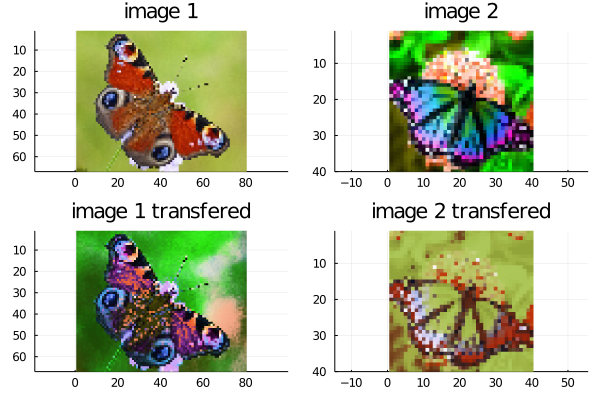

In [78]:
"""
Maps one distribution to the other
"""
mapdistr(X, P) = Diagonal(sum(P, dims=2)[:].^-1) * P * X

image1transf = reshape(mapdistr(colors2, P), size(image1)...)
image2transf = reshape(mapdistr(colors1, P'), size(image2)...)

plot(
plot(image1, title="image 1", aspect_ratio=:equal),
plot(image2, title="image 2", aspect_ratio=:equal),
plot(image1transf, title="image 1 transfered", aspect_ratio=:equal),
plot(image2transf, title="image 2 transfered", aspect_ratio=:equal)
)